# Analysis of the Pareto Fronts after 1000 generations of evolution

In [259]:
import os
import sys

import pandas as pd

sys.path.append("./src/")
#from problem import Problem
#problem = Problem("mlr_rpart")

In [262]:
result_directory = "run"
pareto_front_dataframes = []
for subdirectory in os.listdir(result_directory):
    if '.' in subdirectory:
        continue  # not a directory
        
    algorithm, evolution_strategy = subdirectory.split('_')
    
    for run in os.listdir(os.path.join(result_directory, subdirectory)):
        run_directory = os.path.join(result_directory, subdirectory, run)
        with open(os.path.join(run_directory, "metadata.csv"), 'r') as fh:
            lines = fh.readlines()
            metadata = dict([line[:-1].split(';') for line in lines])
        
        run_pareto = pd.read_csv(os.path.join(run_directory, "final_pareto.csv"), sep=';', header=0)
        run_pareto["algorithm"] = algorithm
        run_pareto["age"] = metadata["age_regularization"]
        run_pareto["target"] = metadata["aggregate"]
        pareto_front_dataframes.append(run_pareto)
        
pareto_fronts = pd.concat(pareto_front_dataframes)

In [263]:
pareto_fronts.head()

,run,fold,task,score,length,expression,algorithm,age,target
0,0453e8aa-cb22-463a-bb9f-cd6b6840d8e7,0,0,0.9932,4,"make_tuple(0.12027035085556685, truediv(add(xv...",glmnet,200.0,median
1,0453e8aa-cb22-463a-bb9f-cd6b6840d8e7,0,168910,0.4376,4,"make_tuple(0.12027035085556685, truediv(add(xv...",glmnet,200.0,median
2,0453e8aa-cb22-463a-bb9f-cd6b6840d8e7,0,3560,0.0556,4,"make_tuple(0.12027035085556685, truediv(add(xv...",glmnet,200.0,median
3,0453e8aa-cb22-463a-bb9f-cd6b6840d8e7,0,190411,0.9868,4,"make_tuple(0.12027035085556685, truediv(add(xv...",glmnet,200.0,median
4,0453e8aa-cb22-463a-bb9f-cd6b6840d8e7,0,12,0.9988,4,"make_tuple(0.12027035085556685, truediv(add(xv...",glmnet,200.0,median


# Performance By Length

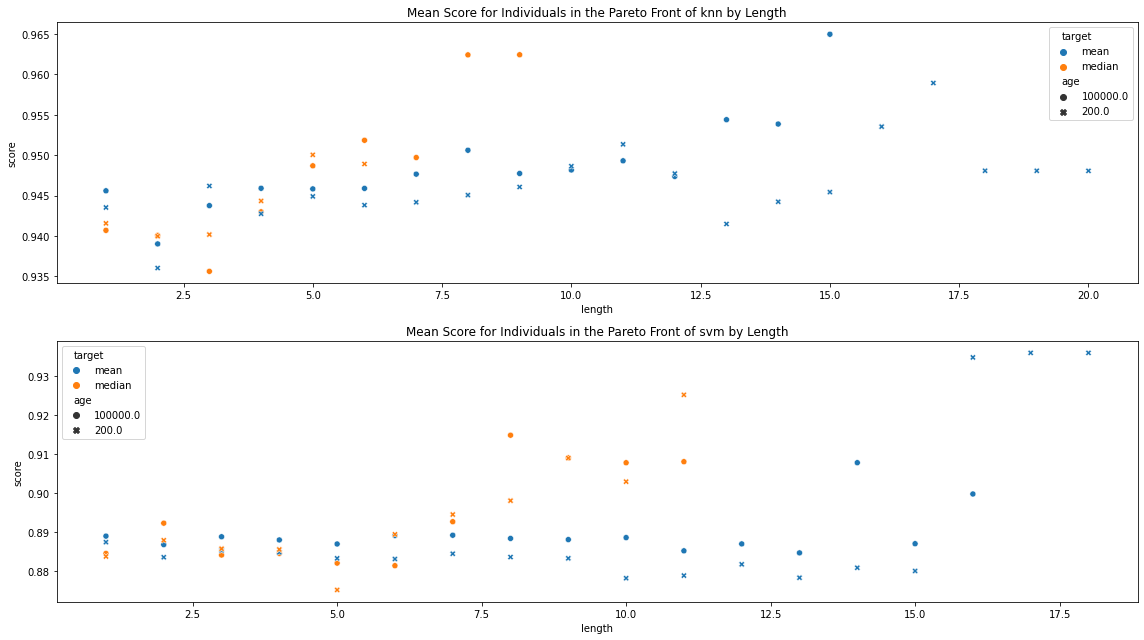

In [29]:
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

validation_data = pareto_fronts[pareto_fronts.task != 0]
validation_data = validation_data[validation_data.algorithm.isin(["knn", "svm"])]
# sns.scatterplot(data=validation_data, x="length", y="score", hue="algorithm", style="age")
# plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

algorithms = list(validation_data.algorithm.unique())
age_settings = list(validation_data.age.unique())
target_settings = list(validation_data.target.unique())

fig, axes = plt.subplots(nrows=len(algorithms), ncols=1, figsize=(16, 9))
for ax, algorithm in zip(axes, algorithms):
    algorithm_data = validation_data[validation_data.algorithm == algorithm]
    data = algorithm_data.groupby(["age", "target", "length"]).score.mean().reset_index()
    sns.scatterplot(data=data, x="length", y="score", hue="target", style="age", ax=ax)
    ax.set_title(f"Mean Score for Individuals in the Pareto Front of {algorithm} by Length")

plt.tight_layout()

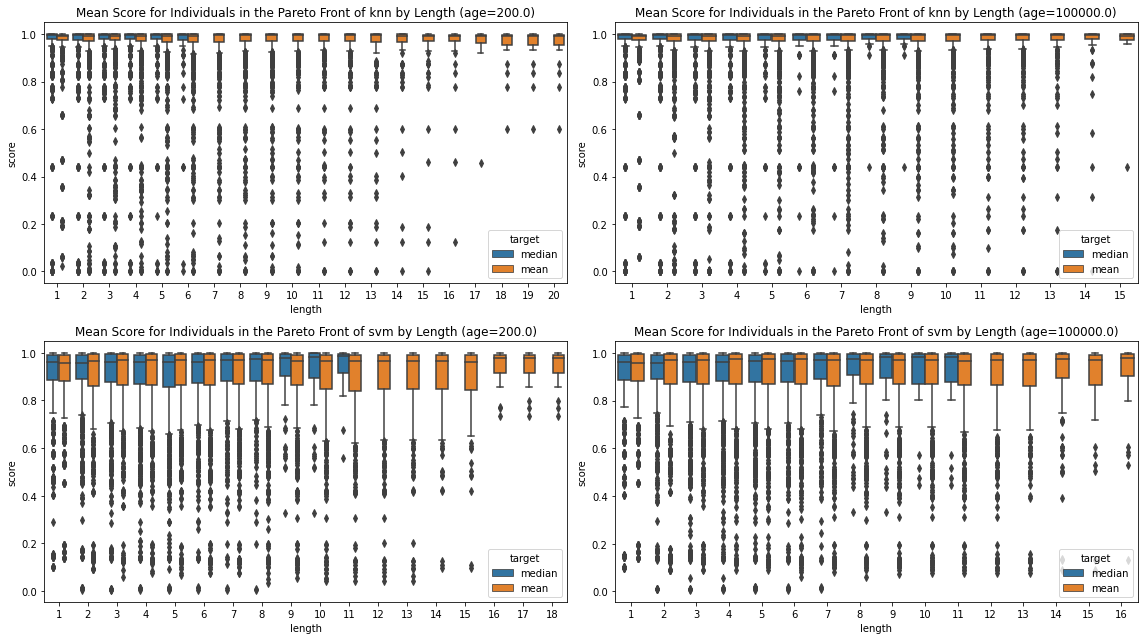

In [40]:
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

validation_data = pareto_fronts[pareto_fronts.task != 0]
validation_data = validation_data[validation_data.algorithm.isin(["knn", "svm"])]
# sns.scatterplot(data=validation_data, x="length", y="score", hue="algorithm", style="age")
# plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

algorithms = list(validation_data.algorithm.unique())
age_settings = list(validation_data.age.unique())
target_settings = list(validation_data.target.unique())

fig, axes = plt.subplots(nrows=len(algorithms), ncols=len(age_settings), figsize=(16, 9))
for ax, (algorithm, age) in zip(axes.flatten(), itertools.product(algorithms, age_settings)):
    algorithm_data = validation_data[(validation_data.algorithm == algorithm) & (validation_data.age == age)]
    # data = algorithm_data.groupby(["target", "length"]).score.mean().reset_index()
    sns.boxplot(data=algorithm_data, x="length", y="score", hue="target", ax=ax)
    ax.set_title(f"Mean Score for Individuals in the Pareto Front of {algorithm} by Length (age={age})")

plt.tight_layout()

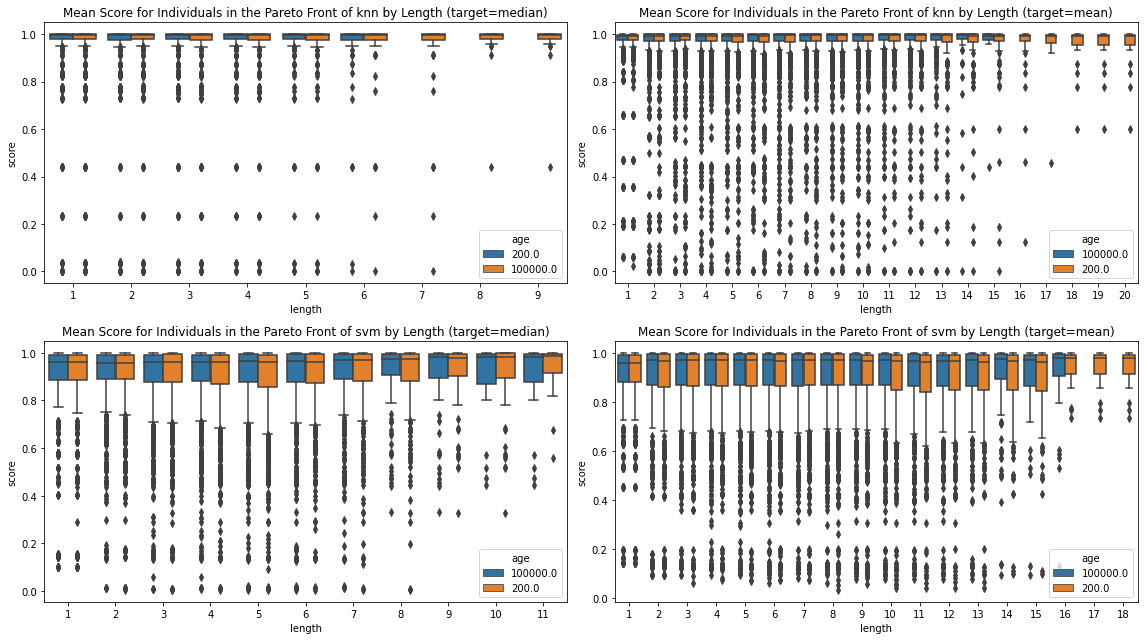

In [42]:
fig, axes = plt.subplots(nrows=len(algorithms), ncols=len(target_settings), figsize=(16, 9))
for ax, (algorithm, age) in zip(axes.flatten(), itertools.product(algorithms, target_settings)):
    algorithm_data = validation_data[(validation_data.algorithm == algorithm) & (validation_data.target == age)]
    sns.boxplot(data=algorithm_data, x="length", y="score", hue="age", ax=ax)
    ax.set_title(f"Mean Score for Individuals in the Pareto Front of {algorithm} by Length (target={age})")

plt.tight_layout()

# Pareto Selection

In [271]:
# we want to include 'task 0' (in-sample) this time around
completed_algorithms = ["knn", "svm", "rpart"]
completed = pareto_fronts[pareto_fronts.algorithm.isin(completed_algorithms)]

selected_hyperparameters = (completed.age != 200) & (completed.target=='mean')
data = completed[selected_hyperparameters].copy()

data['length'] = data['length'].astype(int)
data.head()

,run,fold,task,score,length,expression,algorithm,age,target
0,05daffa6-dd53-439e-922c-9a92c09ee919,2,0,0.9853,11,"make_tuple(max(if_gt(rc, 0.0026121070702410636...",knn,100000.0,mean
1,05daffa6-dd53-439e-922c-9a92c09ee919,2,146820,0.9724,11,"make_tuple(max(if_gt(rc, 0.0026121070702410636...",knn,100000.0,mean
2,05daffa6-dd53-439e-922c-9a92c09ee919,2,9971,0.9999,11,"make_tuple(max(if_gt(rc, 0.0026121070702410636...",knn,100000.0,mean
3,05daffa6-dd53-439e-922c-9a92c09ee919,2,3573,0.9952,11,"make_tuple(max(if_gt(rc, 0.0026121070702410636...",knn,100000.0,mean
4,05daffa6-dd53-439e-922c-9a92c09ee919,2,14971,0.9933,11,"make_tuple(max(if_gt(rc, 0.0026121070702410636...",knn,100000.0,mean


In [275]:
# The following methods assume as input a data frame with data from a single run.
# It contains for each expression in the pareto front, an evaluation on every validation task, 
# and the in-sample score (marked as task 0)

def get_insample_data_with_ranks(df):
    """ Return in-sample data with computed rank, and sorted by length. """
    in_sample_results = df[df.task == 0].copy()
    in_sample_results['rank'] = in_sample_results.score.rank(ascending=False)
    in_sample_results.sort_values(by="length", inplace=True)
    return in_sample_results

def get_validation_data_with_ranks(df):
    """ Return validation data with rank computed on mean scores, and sorted by length. """
    validation_results = df[df.task != 0].copy()
    run_results = validation_results.groupby("expression", as_index=False).mean()
    run_results['rank'] = run_results.score.rank(ascending=False)
    run_results.sort_values(by="length", inplace=True)
    return run_results

def select_best(df, max_len=None, delta=0):
    """ Selects the best individual from the pareto based on the validation scores.
    Parameters can be used to ensure only individuals smaller or equal to `max_len` are picked,
    or that any increase in length also requires at least a performance increase of `delta`.
    """
    validation_results = df[df.task != 0]
    mean_results = validation_results.groupby("expression", as_index=False).mean()
    
    best_so_far = 0
    expression = None
    expression_length = None
    
    # Sorting by length means we sort them by performance on the in-sample training data
    for i, row in mean_results.sort_values(by='length', ascending=True).iterrows():
        if row['score'] > best_so_far + delta and (max_len is None or row['length'] <= max_len):
            best_so_far = row['score']
            expression = row['expression']
            expression_length = row['length']
    
    return expression, best_so_far, expression_length


def combined_rank_select(df, sort='mean'):
    """ Use both the in-sample and validation rank to select an individual.
    Either select the individual with the lowest mean rank, or the lowest rank product.
    """
    metric = f"rank_{sort}"
    in_sample = get_insample_data_with_ranks(df)
    validation = get_validation_data_with_ranks(df)
    
    if sort == "mean":
        validation[metric] = (validation["rank"].values + in_sample["rank"].values) / 2
    elif sort == "product":
        validation[metric] = validation["rank"].values * in_sample["rank"].values
    
    validation.sort_values(metric, inplace=True)
    return validation.iloc[0]['expression'], validation.iloc[0]['score'], validation.iloc[0]['length']

def select_best_with_insample(df, max_rank_decrease=0, max_score_decrease=0):
    """ Select the best in-sample individual for which the `rank` or `score` does not decrease by X 
    Defaults to picking the most simple expression if no other solution meets the criteria.
    """
    in_sample = get_insample_data_with_ranks(df)
    validation = get_validation_data_with_ranks(df)
    
    best_so_far = 0
    expression = None
    expression_length = None
    
    for i, row in in_sample.iterrows():
        validation_row = validation[validation.expression == row['expression']]
        if max_score_decrease != 0:
            if row['score'] - validation_row['score'].values[0] < max_score_decrease:
                best_so_far = row['score']
                expression = row['expression']
                expression_length = row['length']
        else:
            if row['rank'] - validation_row['rank'].values[0] < max_rank_decrease:
                best_so_far = row['score']
                expression = row['expression']
                expression_length = row['length']
    
    if expression is None:
        best_so_far = validation.iloc[0]['score']
        expression = validation.iloc[0]['expression']
        expression_length = validation.iloc[0]['length']
    
    return expression, best_so_far, expression_length

In [298]:
import random
# For each run, find with the best pareto selection strategy using the validation data.

random.seed(0)

n_hps = dict(
    svm=2,
    knn=4,
    rpart=4,
)


all_run_strategies_ranked = []
for run in selected_strategies.run.unique():
    run_result = selected_strategies[selected_strategies.run == run]
    for _ in range(10):
        tasks = list(run_result.task.unique())
        random.shuffle(tasks)
        train_size = len(tasks) - 10

        train, val = tasks[:train_size], tasks[train_size:]
        algorithm = run_result.algorithm.unique()[0]

        strategies_for_run = []
        
        train_data = run_result[run_result.task.isin([*train, 0])]
        validation_data = run_result[run_result.task.isin(val)]
        selections = [
            ("best", select_best(train_data)),
            ("d0_001", select_best(train_data, delta=0.001)),
            ("len_is_hp", select_best(train_data, max_len=n_hps[algorithm] + 1)),
            ("rank_mean", combined_rank_select(train_data)),
            # ("oracle", select_best(validation_data)),
            ("rank_3_worse", select_best_with_insample(train_data, max_rank_decrease=3)),
            #("score_0001_worse", select_best_with_insample(train_data, max_score_decrease=0.001)),
        ]
        for strategy, (expression, score, length) in selections:
            mean_val_score = validation_data[validation_data.expression == expression].score.mean()
            strategies_for_run.append(dict(
                run=run,
                algorithm=algorithm,
                strategy=strategy,
                expression=selected,
                mean_train_score=score,
                mean_val_score=mean_val_score,
                expression_length=length,
            ))

        # Oracle on just validaiton data
        selected, mean_val_score, expr_len = select_best(run_result[run_result.task.isin(val)], max_len=None, delta=0)
        mean_train_score = run_result[(run_result.task.isin(train)) & (run_result.expression == selected)].score.mean()
        strategies_for_run.append(dict(
            run=run,
            algorithm=algorithm,
            strategy="oracle",
            expression=selected,
            mean_train_score=mean_train_score,
            mean_val_score=mean_val_score,
            expression_length=expr_len,
        ))        

        
        strategy_scores = pd.DataFrame.from_dict(strategies_for_run, orient='columns')
        strategy_scores['train_rank'] = strategy_scores.rank(ascending=False).mean_train_score
        strategy_scores['val_rank'] = strategy_scores.rank(ascending=False).mean_val_score
        all_run_strategies_ranked.append(strategy_scores)
    
ranked_strategies_per_run = pd.concat(all_run_strategies_ranked)
        

In [299]:
ranked_strategies_per_run.groupby(["algorithm", "strategy"]).mean()

mean_train_score  mean_val_score  expression_length  \
algorithm strategy                                                            
knn       best                  0.962114        0.949038           4.924731   
          d0_001                0.962031        0.949012           4.359140   
          len_is_hp             0.959568        0.949916           3.230108   
          oracle                0.949545        0.961671           4.863441   
          rank_3_worse          0.975817        0.948242          11.150538   
          rank_mean             0.953411        0.948113           9.467742   
rpart     best                  0.942593        0.929014           5.261856   
          d0_001                0.942487        0.928885           4.576289   
          len_is_hp             0.940481        0.930004           3.387629   
          oracle                0.931011        0.941899           5.346392   
          rank_3_worse          0.956732        0.929559          11.783505   
          rank_mean             0.936351        0.930171           9.708247   
svm       best                  0.904320        0.882784           4.532222   
          d0_001                0.904249        0.882958           3.943333   
          len_is_hp             0.899353        0.882323           1.917778   
          oracle                0.888619        0.900558           4.542222   
          rank_3_worse          0.926858        0.884062          11.755556   
          rank_mean             0.893477        0.884504           9.797778   

                        train_rank  val_rank  
algorithm strategy                            
knn       best            2.589247  3.851075  
          d0_001          2.983333  3.945161  
          len_is_hp       3.506452  3.940860  
          oracle          4.809677  1.556989  
          rank_3_worse    2.875269  3.828495  
          rank_mean       4.236022  3.877419  
rpart     best            2.596907  3.901031  
          d0_001          3.082474  4.040722  
          len_is_hp       3.535567  3.872680  
          oracle          4.937629  1.552577  
          rank_3_worse    2.736598  3.858763  
          rank_mean       4.110825  3.774227  
svm       best            2.474444  4.055556  
          d0_001          2.753889  4.047222  
          len_is_hp       3.744444  4.115556  
          oracle          4.962222  1.561111  
          rank_3_worse    2.870000  3.594444  
          rank_mean       4.195000  3.626111

# Picking Expressions from the Pareto

In [258]:
strategy = "hp_based_max_length" # or "hp_based_max_length"

solutions = []
for algorithm in selected_strategies.algorithm.unique():
    alg_runs = selected_strategies[selected_strategies.algorithm == algorithm]
    tasks = alg_runs.task.unique()

    for task in tasks:
        if task == 0:
            continue
        runs_with_task = alg_runs[alg_runs.task == task]
        chosen_run = runs_with_task.sample().run.values[0]

        run_results = selected_strategies[selected_strategies.run == chosen_run]
        without_target_task = run_results[run_results.task != task]
        
        if strategy == "mean_rank":
            expression, score, length = rank_mean_select(without_target_task)
        elif strategy == "hp_based_max_length":
            max_len = n_hps[algorithm] + 1
            expression, score, length = select_best(without_target_task, max_len)
        solutions.append(dict(algorithm=algorithm, task=task, expression=expression))

pd.DataFrame.from_dict(solutions, orient='columns').to_csv(f"found_by_{strategy}.csv", index=False)
